# Simulate passive QIS camera (SwissSPAD2) 

This tutorial explains how to repurpose the BaseEWHSPC class with appropriate parameters 
to simulate a passive quanta image sensor (QIS) cameras like SwissSPAD2[1].

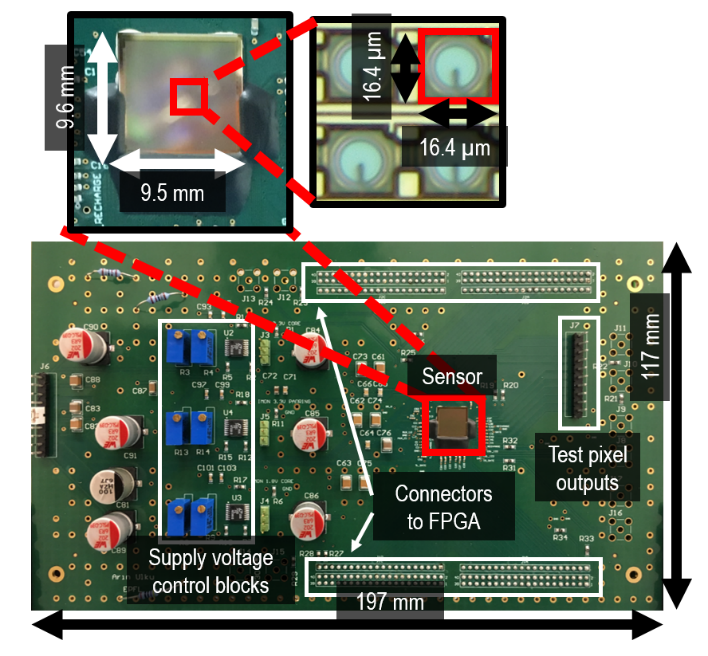

In [10]:
from IPython.display import Image
Image("https://www.epfl.ch/labs/aqua/wp-content/uploads/2018/11/Ultra-high-Speed-Native-Digital-Camera_5.png", width=400)

*Image of SwissSPAD2 camera from [1]*

### Translating the dToF imaging model used by BaseEWHSPC to passive imaging model for QIS cameras.

The BaseEWHSPC uses the following image formation model to simulate the rate of photons incident on the sensor in
the $n^{th}$ time interval as follows

$$ s[n] = \gamma \int^{(n+1)\Delta t}_{n\Delta t} (\Phi_{sig}(t - 2z_0/c) + \Phi_{bkg} ) dt  $$

Where $\gamma$ is the scene reflectivity, $\Phi_{sig}$ is the average signal flux and $\Phi_{bkg}$ represents 
the average background flux. 

For passive imaging we can set $\Phi_{sig} = 0$. Hence the rate of photons incident on the sensor is now 

$$ s[n] = \gamma \Phi_{bkg} \Delta t$$

The number of pixels arriving in time interval $\Delta t$ can be modeled as a Poisson random variable [2]:
$$ \mathcal{P} \{Z = k\} = \frac{s[n]^{k} e^{- s[n]}}{k!}$$

As mentioned in [3] each pixel detects at most one photon during the exposure time $\Delta t$ returning a binary value B = 1 for $k \ge 1$ and B = 0 for $k = 0$.

Hence each pixel measurement is a random variable with Bernoulli distribution [3]: 

$$ \mathcal{P} \{ B = 0\} = \frac{s[n]^{0} e^{- s[n]}}{0!} \\ = \gamma \Phi_{bkg} \Delta t e^{- \gamma \Phi_{bkg} \Delta t} $$

This equation is similar to the equation (2) in [3] if we consider $r_q$ the dark count rate (DCR) negligible compared to $\gamma \Phi_{bkg}$. 

### Setting up the simulator 

In [5]:
from SPCSim.data_loaders.rgbd_loaders import NYULoader1
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils.plot_utils import plot_transient, plot_ewh, plot_edh, plot_edh_traj
import matplotlib.pyplot as plt
from SPCSim.sensors.dtof import RawSPC, BaseEWHSPC
from SPCSim.postproc.ewh_postproc import PostProcEWH
from SPCSim.postproc.edh_postproc import PostProcEDH
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import numpy as np
import imageio
from IPython.display import Image
import time


def simulate_QIS2(Nr, # Number of pixel rows
             Nc, # Number of pixel columns
             N_tbins, # Number of binary frames (nq)
             tmax, # Exposure time to capture nq frames of dt exposure
             device, # Compute device 
             seed_val,
             alpha_sig,
             alpha_bkg_per_sec,
             alpha_bkg_per_tmax,
             pde,
             show_gif = True):

  print("Average photons per exposure time of %r seconds = %f"%(tmax*1e-9, alpha_bkg_per_tmax))
  print("FPS of the binary frames = %f kHz"%(N_tbins/(tmax*1e-9*1e3)))

  # Set the image resolution for the RGB-D frames
  nyu_data = NYULoader1(Nc, Nr, folder="test", device = device)

  rgb_pth = "../../images/00001_colors.png"
  dist_pth ="../../images/00001_depth.png"

  # Access an RGB-D frame using the get_data method
  data = nyu_data.get_data(rgb_pth, dist_pth, rgb_pth, rgb_pth)

  # Creating transient generator with laser time period of tmax ns, FWHM and with
  # laser time period divided into N_tbins equal time-bins
  tr_gen = TransientGenerator(Nr = Nr, Nc = Nc, N_tbins = N_tbins, tmax = tmax, device = device)

  # Setting the dimensions, device, number of EWH bins per pixel
  # and number of laser pulses

  device = nyu_data.device

  # Setting number of pulses = 1 (single cycle is enough as it simulates 1000 frames for N_tbins=1000)
  N_pulses = 1
  N_ewhbins = N_tbins # Setting the EWH bins = N_frames each bin will either be 1 or 0

  spc1 = BaseEWHSPC(
                  Nr,
                  Nc,
                  N_pulses,
                  device,
                  N_tbins,
                  N_ewhbins
                )

  start = time.time()

  
  # Using the get function to generate the transient
  # for a given distance, albedo, intensity, and illumination condition

  phi_bar = tr_gen.get_transient(data["gt_dist"], # NOTE: the true distance is in meters and depends on tmax
                                data["albedo"]*1.0/255.0,
                                data["albedo"]*1.0/255.0,
                                torch.tensor(alpha_sig),
                                torch.tensor(alpha_bkg_per_tmax))



  captured_data = spc1.capture(phi_bar)
  ewh_data = captured_data["ewh"]

  end1 = time.time()

  ewh_data = ewh_data.cpu().numpy()

  phi_bar = phi_bar.cpu()

  print("phi_bar stats", phi_bar.mean(), phi_bar.min(), phi_bar.max())

  print("Time to generate photon cube %r s"%(end1-start))
  
  ewh_bins_axis = torch.linspace(0,N_tbins-N_tbins//N_ewhbins,N_ewhbins)

  fig, ax = plt.subplots(1,1,figsize=(8,4))
  ROW, COL = [0,0]
  plot_ewh(ax, ewh_bins_axis, ewh_data[ROW, COL,:], label = "EWH histogram", color = 'w')
  ax.set_xlabel("Time (a.u.)")
  ax.set_ylabel("Photon counts")
  ax.set_title("View a single pixel of the photon cube")
  
  fig2, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
  ax1.imshow(ewh_data[:,:,0], cmap="gray")
  ax1.set_title(r'First frame of photon cube')
  ax2.imshow(np.mean(ewh_data,-1), cmap="gray")
  ax2.set_title(r'Average of the photon cube $\frac{\sum B}{N_{frames}}$')


  M = np.mean(ewh_data,-1)

  phi_pred = -np.log(1-M)/(tmax*1e-9*pde/N_ewhbins)

  ax3.imshow(phi_pred, cmap="gray")
  ax3.set_title(r'MLE of the intensity image $\hat\Phi$')
  plt.suptitle(r'MLE $\hat\Phi$ = %.4f and true $\Phi$ = %.4f'%( np.mean(phi_pred), alpha_bkg_per_sec))
  plt.show()
  
  # print("mean MLE predicted phi_per_sec, assumed phi_per_sec", np.mean(phi_pred), alpha_bkg_per_sec)
  print("Sweeping through the binary frames of the photon data cube")

  if show_gif:

    images = []

    # Make it pause at the end so that the viewers can ponder
    for i in range(N_ewhbins):
        images.append((ewh_data[:,:,i]*255.0).astype(np.uint8))

    imageio.mimsave('movie.gif', images, fps=100)


    with open('movie.gif','rb') as f:
        display(Image(data=f.read(), format='png'))

### Setting parameters of BaseEWHSPC to simulate SwissSPAD2

Considering the following lines from [1] 

` The frame readout is performed in 10 μs in a rolling shutter mode (with global shutter exposure). Note that only one photon can be detected during the readout cycle. The choice of a 1-bit digital pixel maximizes fill factor and eliminates readout noise, leaving dark counts (and afterpulsing) as the only noise sources in the system. ... and the PDE (PDP of 35% and fill factor of 10.5%) of SwissSPAD2.`

And considering the following lines from [2]

`This SPAD camera can capture binary frames at a spatial resolution of 512×256. The maximum frame rate of the camera is 96.8kHz.`

* Photon detection efficiency PDE = 3.675% (i.e. 0.35*0.105)
* $\Delta t = 10 \mu s$
* FPS = 100000 (Approximating to 100kHz frame rate)
* Frames per photon cube = 1000

We treat individual t_bins in the BaseEWHSPC as the binary frames and we treat tmax as the total time taken to capture the photon cube. 

* Hence `N_tbins = 1000` and resolution of each t_bin = $10 \mu s$, and the total 
exposure time `tmax = N_tbins*bin_resolution = 10 ms`.
* Assuming background flux of 0.1 photons per 100ns ( considering lower flux to avoid pileup effects) we set $\Phi_{bkg} = 1000000$ cps. 
    * Note that this will get multiplied by PDE = 0.03675
* Considering PDE = 0.03675, the average background pixels detected per SPAD pixel (`eff_alpha_bkg_per_tmax = PDE*\Phi_{bkg}*tmax`)
* The scene reflectivity $\gamma$ is modeled in the TransientGenerator class which takes input intensity image as an estimate of $\gamma$ for each scene point.

367.49999999999994
Average photons per exposure time of 0.009999999999999998 seconds = 367.500000
FPS of the binary frames = 100.000000 kHz
phi_bar stats tensor(0.3675, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(0.6511, dtype=torch.float64)
Time to generate photon cube 0.0019142627716064453 s


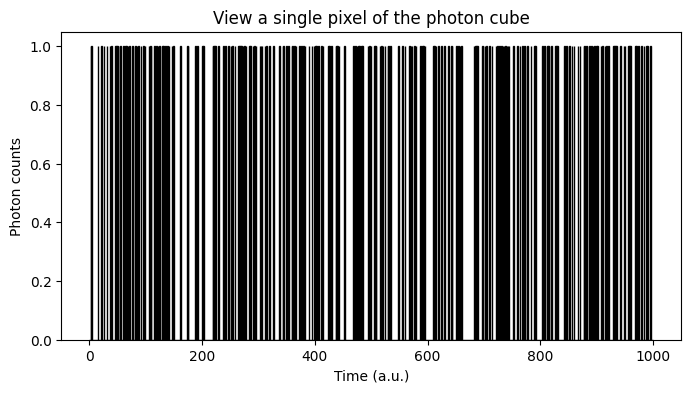

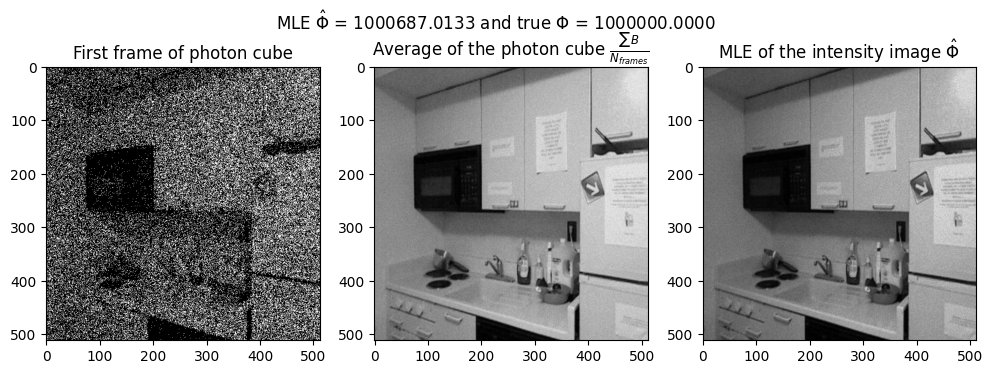

Sweeping through the binary frames of the photon data cube


In [12]:

Nr, Nc = [512,512]
N_frames = 1000
N_tbins = N_frames # Setting number of binary frames generated per photon cube 
bin_resolution = 10*1e-6 # 10 micro second exposure per binary frame
tmax = bin_resolution*N_frames*1e9 # Exposure time of photon cube in nano seconds units
N_ewhbins = N_tbins # Setting N_ewhbins such that each EWH bin corresponds to a binary frame
device = "cuda"
N_pulses = 1 # We generate 1 photon cube of N_frames binary frames setting N_pulses = 1
seed_val = 49
alpha_sig = 0 # Set signal = 0 for to use BaseEWHSPC as passive sensor
alpha_bkg_per_sec = 1000000 # background photon counts per second
pde = 0.03675 # Considering PDE of 3.675%
alpha_bkg_per_tmax = pde*alpha_bkg_per_sec*(tmax*1e-9) # Average background flux per exposure time
print(alpha_bkg_per_tmax)

simulate_QIS2(Nr,
             Nc,
             N_tbins,
             tmax,
             device,
             seed_val,
             alpha_sig,
             alpha_bkg_per_sec,
             alpha_bkg_per_tmax,
             pde,
             show_gif = False)

### References

[1] Arin Can Ulku, Claudio Bruschini, Ivan Michel Antolovic, Yung Kuo, Rinat Ankri, Shimon Weiss, Xavier Michalet, and Edoardo Charbon. 2019.  A 512 × 512 SPAD  Image Sensor With Integrated Gating for Widefield FLIM. IEEE Journal of Selected  Topics in Quantum Electronics 25, 1 (Jan. 2019), 1–12.

[2] Feng Yang, Y. M. Lu, L. Sbaiz, and M. Vetterli. 2012. Bits From Photons: Oversampled  Image Acquisition Using Binary Poisson Statistics. IEEE Transactions on Image  Processing 21, 4 (April 2012), 1421–1436.

[3] Sizhuo Ma, Shantanu Gupta, Arin C. Ulku, Claudio Bruschini, Edoardo Charbon, and Mohit Gupta. 2020. Quanta burst photography. ACM Trans. Graph. 39, 4, Article 79 (August 2020), 16 pages. https://doi.org/10.1145/3386569.3392470

[4] D. V. O’Connor and D. Phillips, Time-Correlated Single Photon Counting (Academic, 1984).